In [146]:
import file_reader as fr
import itertools as it
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
ephys_data = fr.get_ephys_data()

In [35]:
gamble_choices = fr.get_gamble_choices_data()

In [36]:
behavior_data = fr.get_behavior_data()

C:\Users\MariLiis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
regressor_data = fr.get_regressor_data()

In [80]:
SUBJECTS = ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10"]

In [38]:
print(ephys_data.keys())
print(behavior_data.keys())

dict_keys(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10'])
dict_keys(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10'])


In [39]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [40]:
gamble_choices['Risky.Bet.Amount'].value_counts()

20    59
25    48
15    47
30    46
Name: Risky.Bet.Amount, dtype: int64

In [41]:
gamble_choices['Risky.bet.shown.number'].value_counts()

6     24
5     24
4     24
1     22
8     21
7     19
2     18
3     16
9     11
0     11
10    10
Name: Risky.bet.shown.number, dtype: int64

In [42]:
sub1_ephys = ephys_data["s1"]
sub1_behavior = behavior_data["s1"]
sub1_behavior.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1


In [44]:
df = pd.concat([sub1_behavior, gamble_choices[["Risky.Bet.Amount", "Risky.bet.shown.number"]]], axis=1)
df.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included,Risky.Bet.Amount,Risky.bet.shown.number
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1,30,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1,20,4
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1,25,7
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1,30,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1,25,6


In [46]:
df['choice.class'].value_counts()

Gamble     124
Safebet     72
Timeout      4
Name: choice.class, dtype: int64

In [47]:
X = df[df['choice.class'] != 'Timeout'][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
X.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [167]:
X_norm = (X - X.mean()) / (X.max() - X.min())
X_norm.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.487923,-0.384058
1,-0.178744,-0.084058
2,0.154589,0.215942
3,0.487923,-0.384058
4,0.154589,0.115942


In [185]:
df = X['Risky.Bet.Amount']
df_norm = (df - df.mean()) / (df.max() - df.min())

In [49]:
y = df[df['choice.class'] != 'Timeout']['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
y.head()

0    1
1    1
2    0
3    1
4    0
Name: choice.class, dtype: int64

In [81]:
sub1_behavior[sub1_behavior['choice.class'] == 'Timeout']

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [83]:
idx = sub1_behavior[sub1_behavior['choice.class'] == 'Timeout'].index
idx

Int64Index([11, 15, 110, 156], dtype='int64')

In [84]:
sub1_behavior.iloc[idx]

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [109]:
def make_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        data[s] = (X, y)
    return data

In [168]:
def make_normalized_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        X_norm = (X - X.mean()) / (X.max() - X.min()) # normalize data
        data[s] = (X_norm, y)
    return data

In [110]:
data = make_data()

In [177]:
data_norm = make_normalized_data()

In [153]:
data['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [178]:
data_norm['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [154]:
logr = LogisticRegression()
print(cross_val_score(logr, X, y, cv=5)) 
lasso = LassoCV()
print(cross_val_score(lasso, X, y, cv=5)) 
ridge = RidgeCV()
print(cross_val_score(ridge, X, y, cv=5)) 
linsvc = LinearSVC()
print(cross_val_score(linsvc, X, y, cv=5))
nusvc = NuSVC()
print(cross_val_score(nusvc, X, y, cv=5))
svc = SVC()
print(cross_val_score(svc, X, y, cv=5))
dt = DecisionTreeClassifier()
print(cross_val_score(dt, X, y, cv=5))
edt = ExtraTreeClassifier()
print(cross_val_score(edt, X, y, cv=5))
rf = RandomForestClassifier()
print(cross_val_score(rf, X, y, cv=5))
enet = ElasticNetCV()
print(cross_val_score(enet, X, y, cv=5))
sgd = SGDClassifier()
print(cross_val_score(sgd, X, y, cv=5))

[0.60714286 0.57142857 0.57142857 0.53571429 0.61538462]
[-0.1551157  -0.00793565 -0.13306474 -0.02166029 -0.05124861]
[-0.16406341  0.02481855 -0.16192645 -0.09415026 -0.24727007]
[0.42857143 0.5        0.57142857 0.57142857 0.53846154]
[0.35714286 0.42857143 0.42857143 0.5        0.53846154]
[0.57142857 0.46428571 0.53571429 0.42857143 0.61538462]
[0.57142857 0.42857143 0.60714286 0.42857143 0.53846154]
[0.57142857 0.42857143 0.60714286 0.39285714 0.53846154]
[0.46428571 0.46428571 0.64285714 0.5        0.53846154]
[-0.1551157  -0.00793565 -0.13306474 -0.02166029 -0.05124861]
[0.57142857 0.57142857 0.57142857 0.42857143 0.42307692]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\MariLiis\Anaconda

In [79]:
MODELS = ["LR", "LASSO", "RIDGE", "LINSVC", "NUSVC", "SVC", "ELNET", "SGD"]

In [108]:
np.array([[1,2], [3,4]]).mean(axis=0)

A = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
b = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
for i1, i2 in kf.split(A):
    print(i1, i2)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [141]:
def cross_validation(X, y, model, k=5):
    test_accuracies = []
    train_accuracies = []
    X_weights = []
    kf = KFold(n_splits=k)
    
    for idx_tr, idx_te in kf.split(X):
        X_train = X.iloc[idx_tr]
        y_train = y.iloc[idx_tr]
        
        X_test = X.iloc[idx_te]
        y_test = y.iloc[idx_te]
        
        if model == "LR":
            logr = LogisticRegression()
            logr.fit(X_train, y_train)
            test_accuracies.append(logr.score(X_test, y_test))
            train_accuracies.append(logr.score(X_train, y_train))
            X_weights.append(logr.coef_)
        
        elif model == "LSVC":
            lsvc = LinearSVC()
            lsvc.fit(X_train, y_train)
            test_accuracies.append(lsvc.score(X_test, y_test))
            train_accuracies.append(lsvc.score(X_train, y_train))
            X_weights.append(lsvc.coef_)
    
    mean_test = round(np.array(test_accuracies).mean(), 3)
    mean_train = round(np.array(train_accuracies).mean(), 3)
    
    return np.array(X_weights).mean(axis=0)[0], mean_test, mean_train

In [170]:
def test_LR_LSVC(data):
    mean_coefs_LR = []
    mean_coefs_LSVC = []
    test_accs_LR = []
    train_accs_LR = []
    test_accs_LSVC = []
    train_accs_LSVC = []

    for s in SUBJECTS:
        X, y = data[s]
        print("Subject", s)
        coefs_LR, mean_test_LR, mean_train_LR = cross_validation(X, y, "LR")
        mean_coefs_LR.append(coefs_LR)
        test_accs_LR.append(mean_test_LR)
        train_accs_LR.append(mean_train_LR)
        print("Model LR, mean test acc %f, train acc %f" % (mean_test_LR, mean_train_LR))        

        coefs_LSVC, mean_test_LSVC, mean_train_LSVC = cross_validation(X, y, "LSVC")    
        mean_coefs_LSVC.append(coefs_LSVC)
        test_accs_LSVC.append(mean_test_LSVC)
        train_accs_LSVC.append(mean_train_LSVC)
        print("Model LR, mean test acc %f, train acc %f" % (mean_test_LSVC, mean_train_LSVC))

    return mean_coefs_LR, test_accs_LR, train_accs_LR, mean_coefs_LSVC, test_accs_LSVC, train_accs_LSVC

In [171]:
mean_coefs_LR, test_accs_LR, train_accs_LR, mean_coefs_LSVC, test_accs_LSVC, train_accs_LSVC = test_LR_LSVC(data)

Subject s1
Model LR, mean test acc 0.786000, train acc 0.782000
Model LR, mean test acc 0.761000, train acc 0.768000
Subject s2
Model LR, mean test acc 0.879000, train acc 0.893000
Model LR, mean test acc 0.879000, train acc 0.876000
Subject s3
Model LR, mean test acc 0.690000, train acc 0.696000
Model LR, mean test acc 0.680000, train acc 0.645000
Subject s4
Model LR, mean test acc 0.389000, train acc 0.532000
Model LR, mean test acc 0.665000, train acc 0.471000
Subject s5
Model LR, mean test acc 0.699000, train acc 0.739000
Model LR, mean test acc 0.647000, train acc 0.677000
Subject s6
Model LR, mean test acc 0.895000, train acc 0.895000
Model LR, mean test acc 0.885000, train acc 0.896000
Subject s7
Model LR, mean test acc 0.865000, train acc 0.876000
Model LR, mean test acc 0.885000, train acc 0.900000
Subject s8
Model LR, mean test acc 0.680000, train acc 0.691000
Model LR, mean test acc 0.610000, train acc 0.674000
Subject s9
Model LR, mean test acc 0.805000, train acc 0.825000


In [179]:
mean_coefs_LR_n, test_accs_LR_n, train_accs_LR_n, mean_coefs_LSVC_n, test_accs_LSVC_n, train_accs_LSVC_n = test_LR_LSVC(data_norm)

Subject s1
Model LR, mean test acc 0.791000, train acc 0.804000
Model LR, mean test acc 0.796000, train acc 0.796000
Subject s2
Model LR, mean test acc 0.919000, train acc 0.919000
Model LR, mean test acc 0.924000, train acc 0.924000
Subject s3
Model LR, mean test acc 0.670000, train acc 0.705000
Model LR, mean test acc 0.680000, train acc 0.708000
Subject s4
Model LR, mean test acc 0.417000, train acc 0.556000
Model LR, mean test acc 0.398000, train acc 0.561000
Subject s5
Model LR, mean test acc 0.724000, train acc 0.737000
Model LR, mean test acc 0.709000, train acc 0.745000
Subject s6
Model LR, mean test acc 0.915000, train acc 0.921000
Model LR, mean test acc 0.935000, train acc 0.935000
Subject s7
Model LR, mean test acc 0.905000, train acc 0.908000
Model LR, mean test acc 0.900000, train acc 0.909000
Subject s8
Model LR, mean test acc 0.675000, train acc 0.706000
Model LR, mean test acc 0.680000, train acc 0.711000
Subject s9
Model LR, mean test acc 0.835000, train acc 0.834000


In [172]:
def plot_LR_LSVC_accs(test_accs_LR, train_accs_LR, test_accs_LSVC, train_accs_LSVC):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes = axes.flatten()

    data1 = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "accuracy": test_accs_LR + train_accs_LR, 
                             "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
    sns.pointplot(x="subject", y="accuracy", hue="type", data=data1, dodge=True, ax=axes[0]).set(
        title="Logistic regression accuracies")

    data2 = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "accuracy": test_accs_LSVC + train_accs_LSVC, 
                             "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
    sns.pointplot(x="subject", y="accuracy", hue="type", data=data2, dodge=True, ax=axes[1]).set(
        title="Linear SVC accuracies")

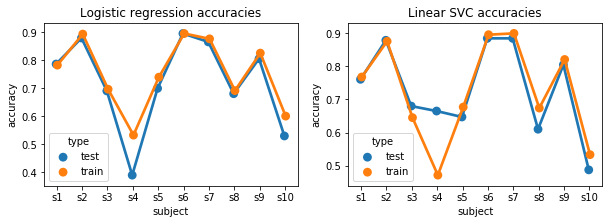

In [173]:
plot_LR_LSVC_accs(test_accs_LR, train_accs_LR, test_accs_LSVC, train_accs_LSVC)

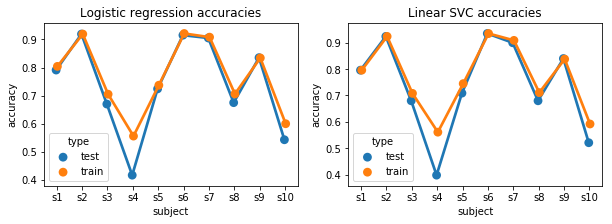

In [180]:
plot_LR_LSVC_accs(test_accs_LR_n, train_accs_LR_n, test_accs_LSVC_n, train_accs_LSVC_n)

In [152]:
mean_coefs_LR

[array([ 0.04032159, -0.50131077]),
 array([ 0.17058673, -1.18101735]),
 array([ 0.00869975, -0.28982903]),
 array([-0.00599965,  0.05446375]),
 array([ 0.02752557, -0.17259601]),
 array([ 0.0805763 , -0.86494762]),
 array([ 0.11977995, -1.00520484]),
 array([-0.00928574, -0.36015005]),
 array([ 0.10818413, -0.87783559]),
 array([-0.00549578, -0.04970497])]

In [160]:
np.array(mean_coefs_LR)[:, 0]

array([ 0.04032159,  0.17058673,  0.00869975, -0.00599965,  0.02752557,
        0.0805763 ,  0.11977995, -0.00928574,  0.10818413, -0.00549578])

In [181]:
def plot_LR_LSVC_coefs(mean_coefs_LR, mean_coefs_LSVC):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes = axes.flatten()

    LR_data = pd.DataFrame({"prize_coef": np.array(mean_coefs_LR)[:, 0],
                            "rnd_nr_coef": np.array(mean_coefs_LR)[:, 1], 
                            "subject": SUBJECTS}) 
    sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=LR_data, ax=axes[0]).set(title="Logistic regression coefs")

    LSVC_data = pd.DataFrame({"prize_coef": np.array(mean_coefs_LSVC)[:, 0],
                            "rnd_nr_coef": np.array(mean_coefs_LSVC)[:, 1], 
                            "subject": SUBJECTS}) 
    sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=LSVC_data, ax=axes[1]).set(title="Linear SVC coefs")

    # Show only one legend 
    axes[0].legend().remove()
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

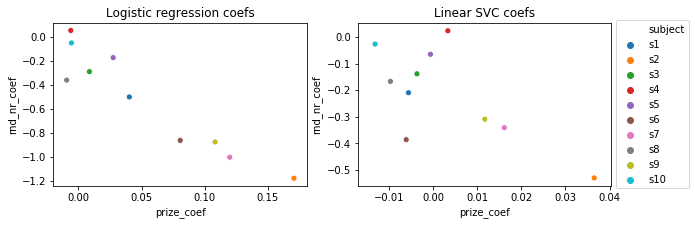

In [182]:
plot_LR_LSVC_coefs(mean_coefs_LR, mean_coefs_LSVC)

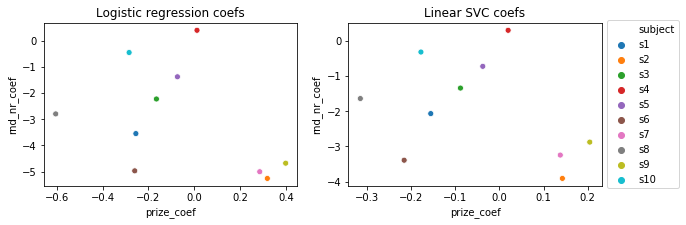

In [183]:
plot_LR_LSVC_coefs(mean_coefs_LR_n, mean_coefs_LSVC_n)